In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *


In [4]:
results=pd.DataFrame()
for fstype in ['zfs','raw','ext4','xfs']:
    tmp=open_result(fstype)
    results= pd.concat([results, tmp], ignore_index=True)

# Single node result
The aim of this experiment is to assess the performance of a single node, so verify the HDDs, the Controller and the machine in general.


## `raw` I/O result

The following plots show the single drive performance without any kind of filesystem. 

<Figure size 3520x2640 with 0 Axes>

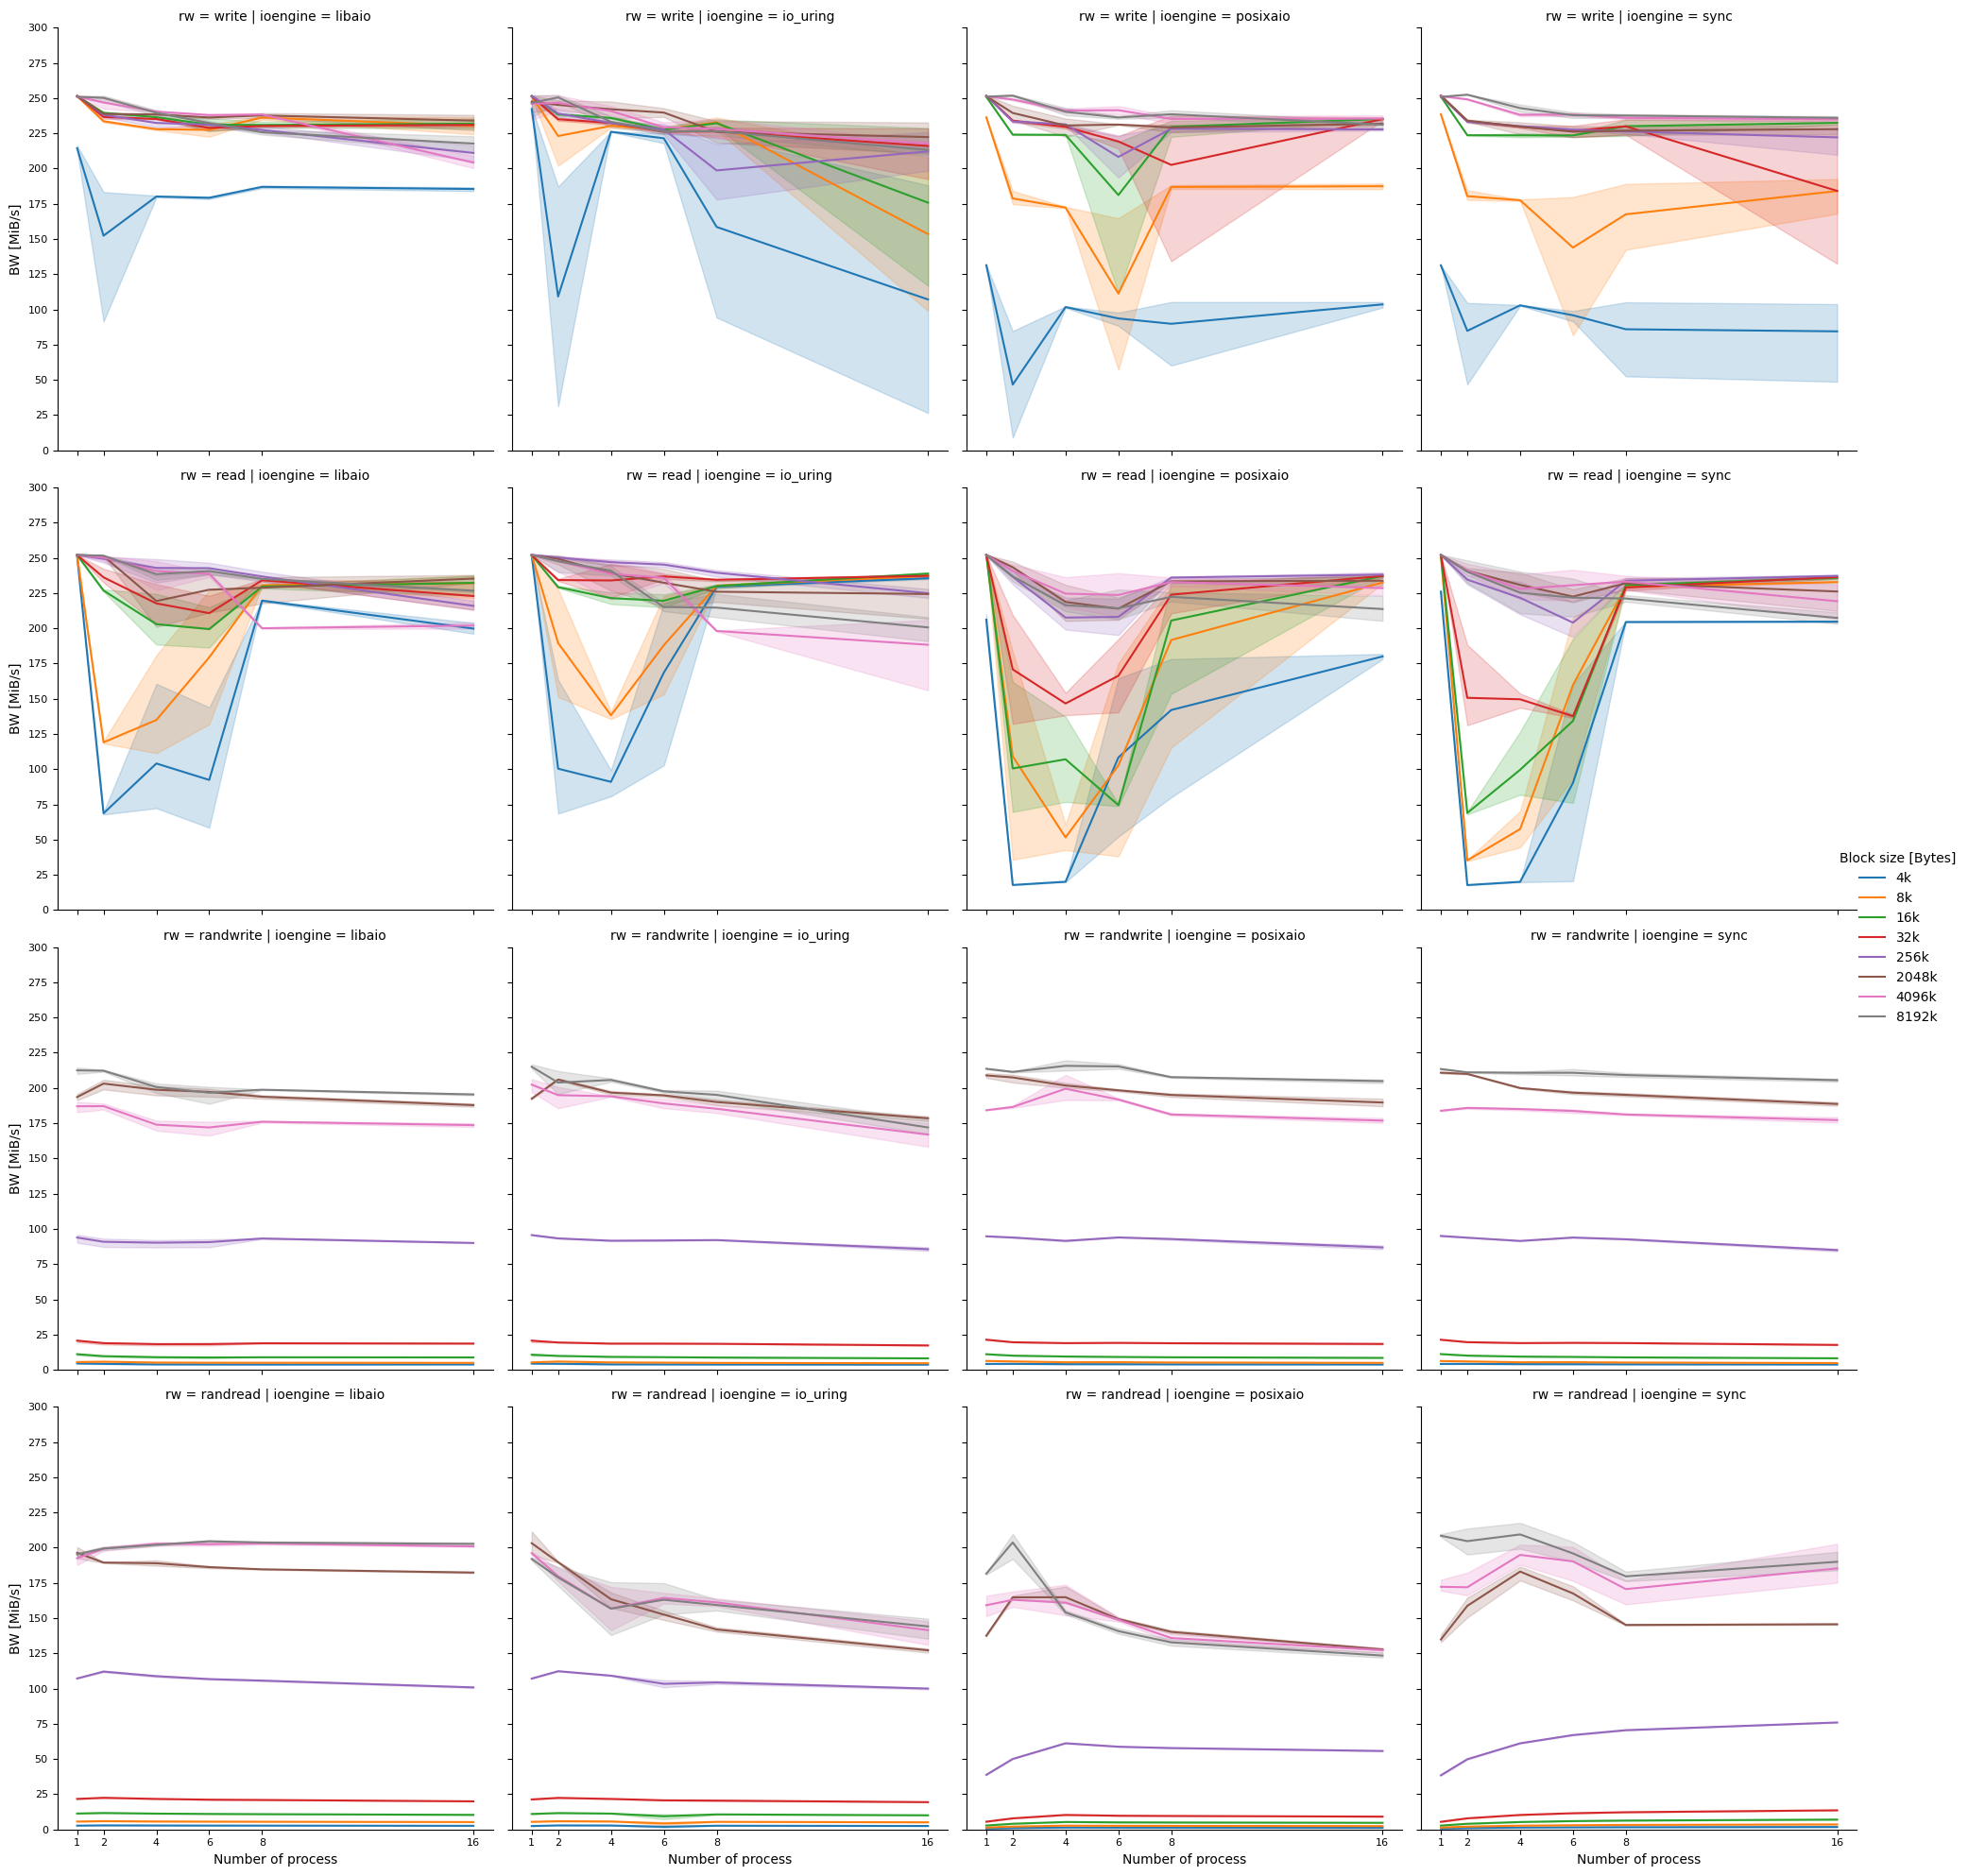

In [5]:
plt.figure(dpi=550)
plot_results('raw',results)

In [6]:
print_table_max_mean_min(results,"raw")

Result on raw,test read
 Max 252.6098461151123 MiB/s
Result on raw,test write
 Max 252.36540508270264 MiB/s
Result on raw,test randread
 Max 700.593994140625 IOPS
Result on raw,test randwrite
 Max 1184.298583984375 IOPS


## `xfs` I/O result

<Figure size 3520x2640 with 0 Axes>

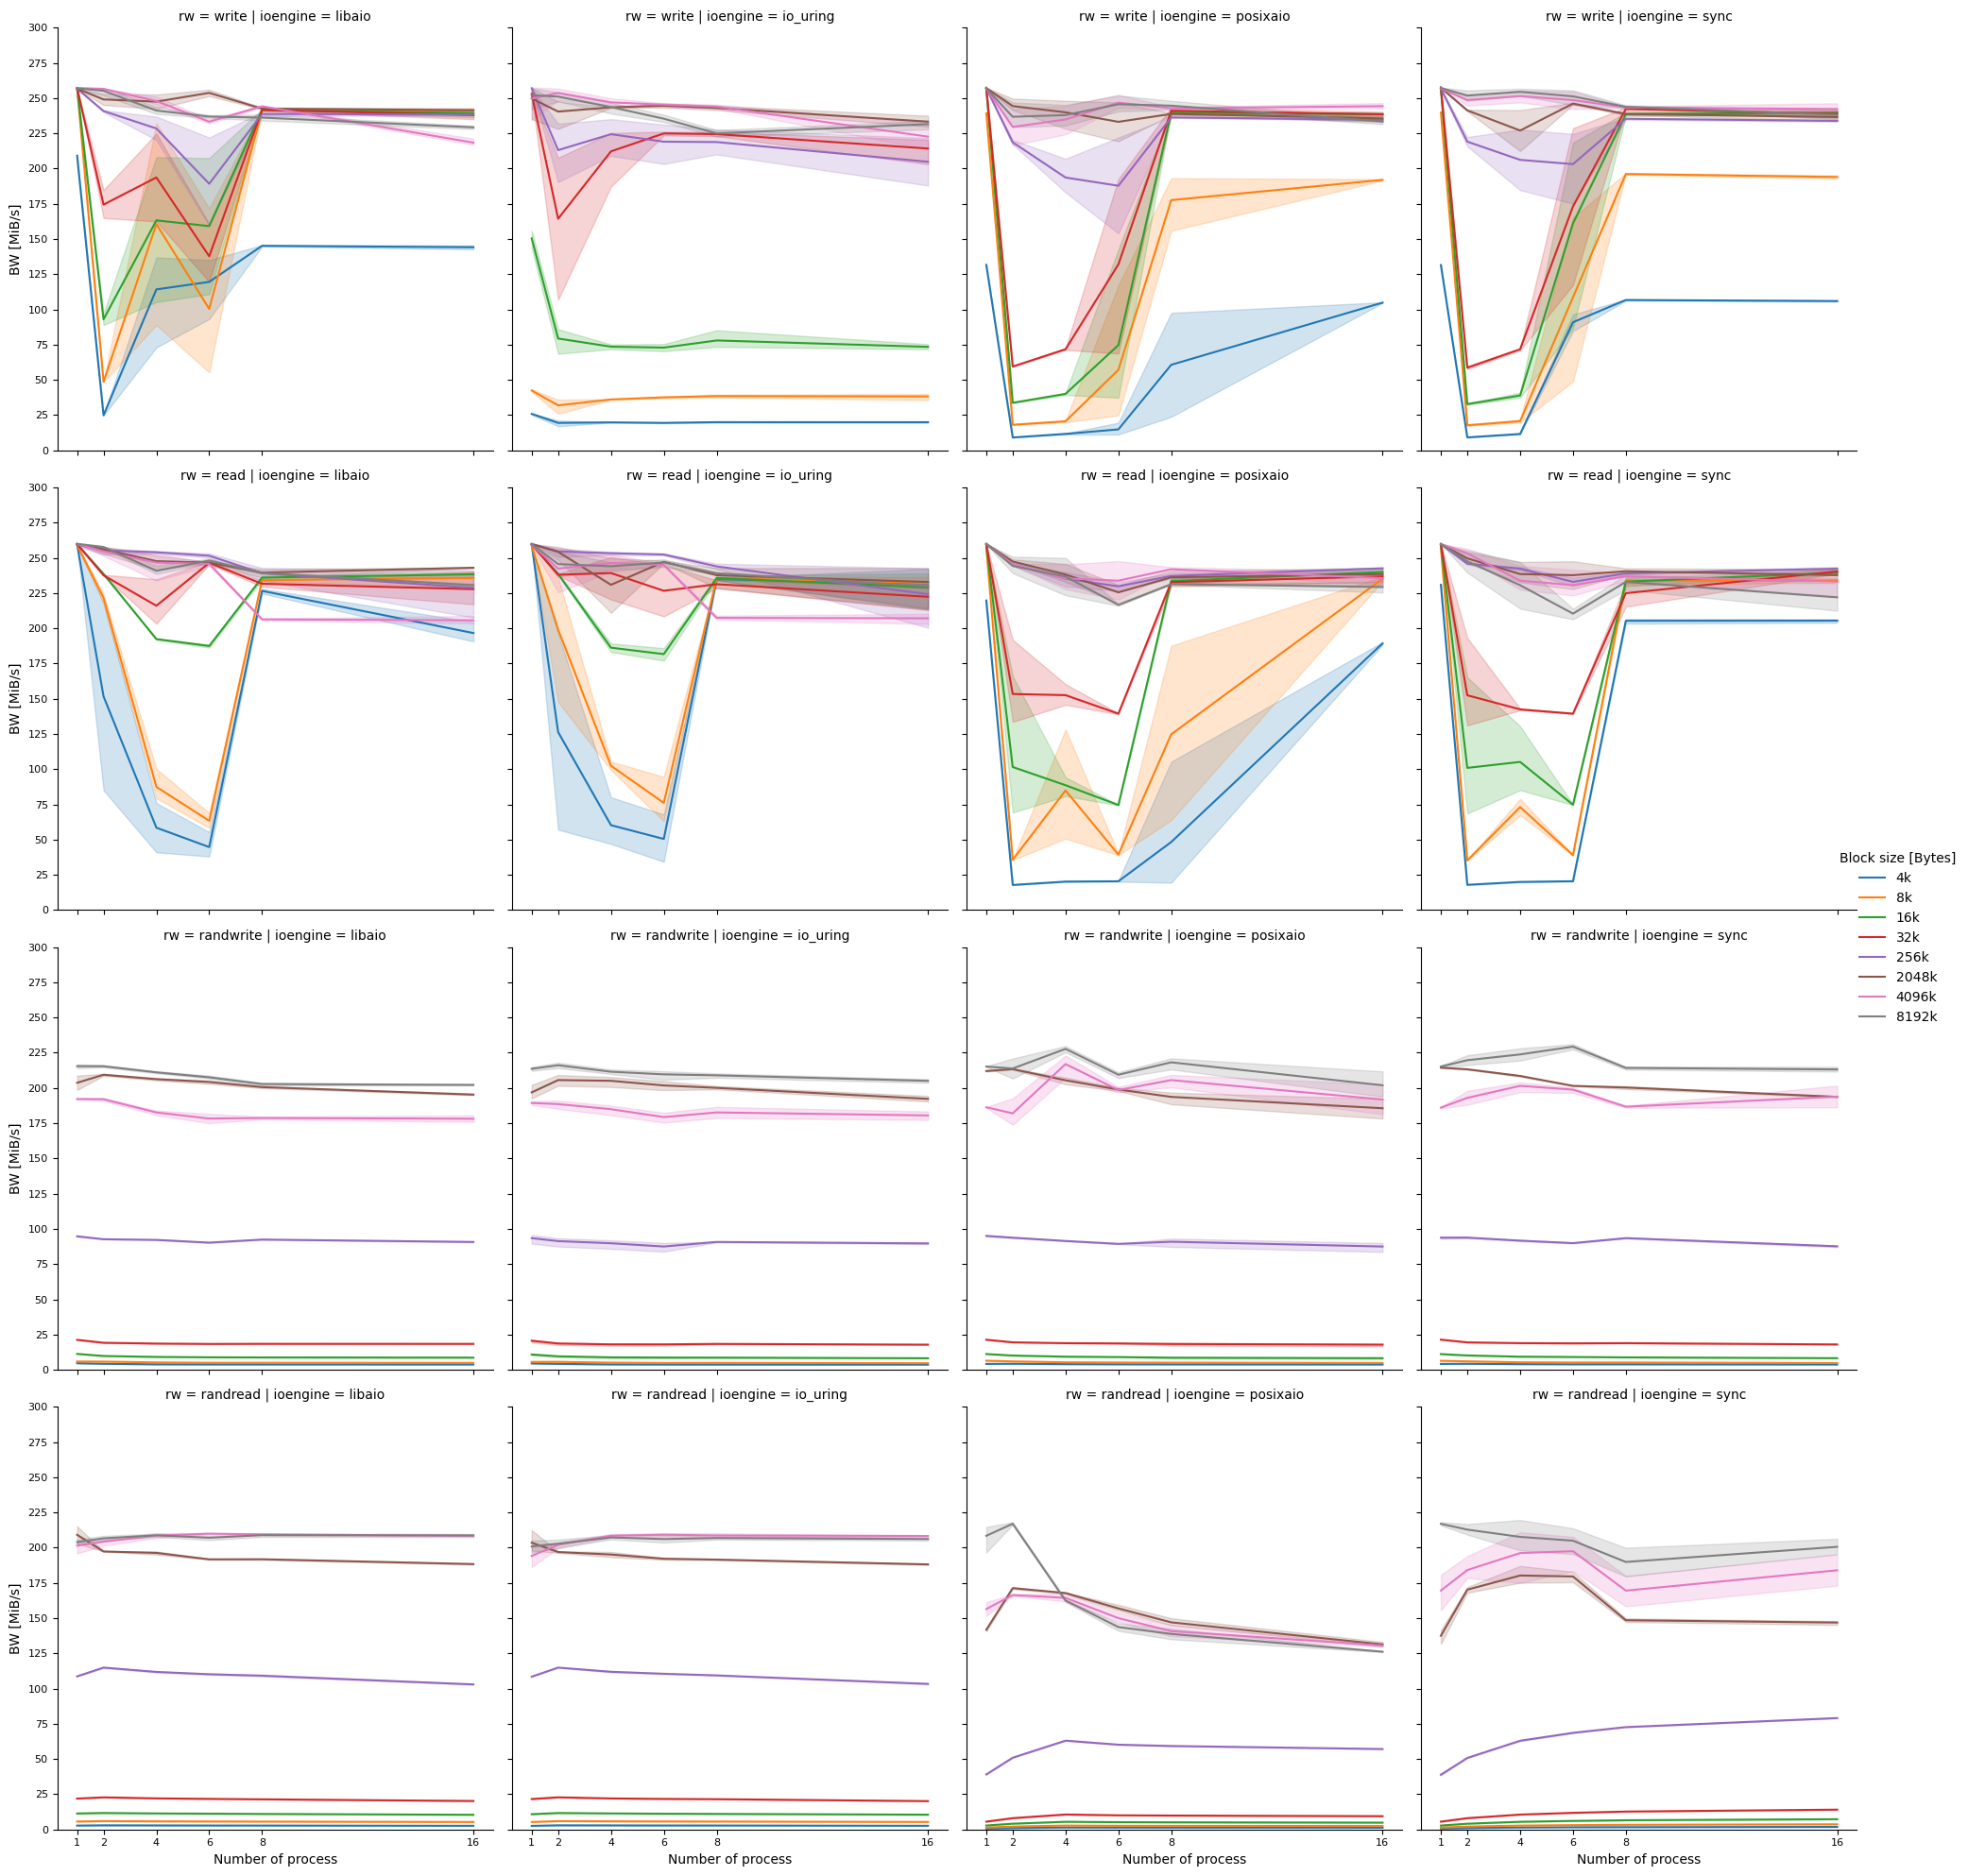

In [5]:
plt.figure(dpi=550)
plot_results('xfs',results)

In [6]:
print_table_max_mean_min(results,"xfs")

Result on xfs,test read
 Max 260.06954193115234 MiB/s
Result on xfs,test write
 Max 258.10104179382324 MiB/s
Result on xfs,test randread
 Max 708.1259765625 IOPS
Result on xfs,test randwrite
 Max 1192.091064453125 IOPS


## `ext4` I/O result

<Figure size 3520x2640 with 0 Axes>

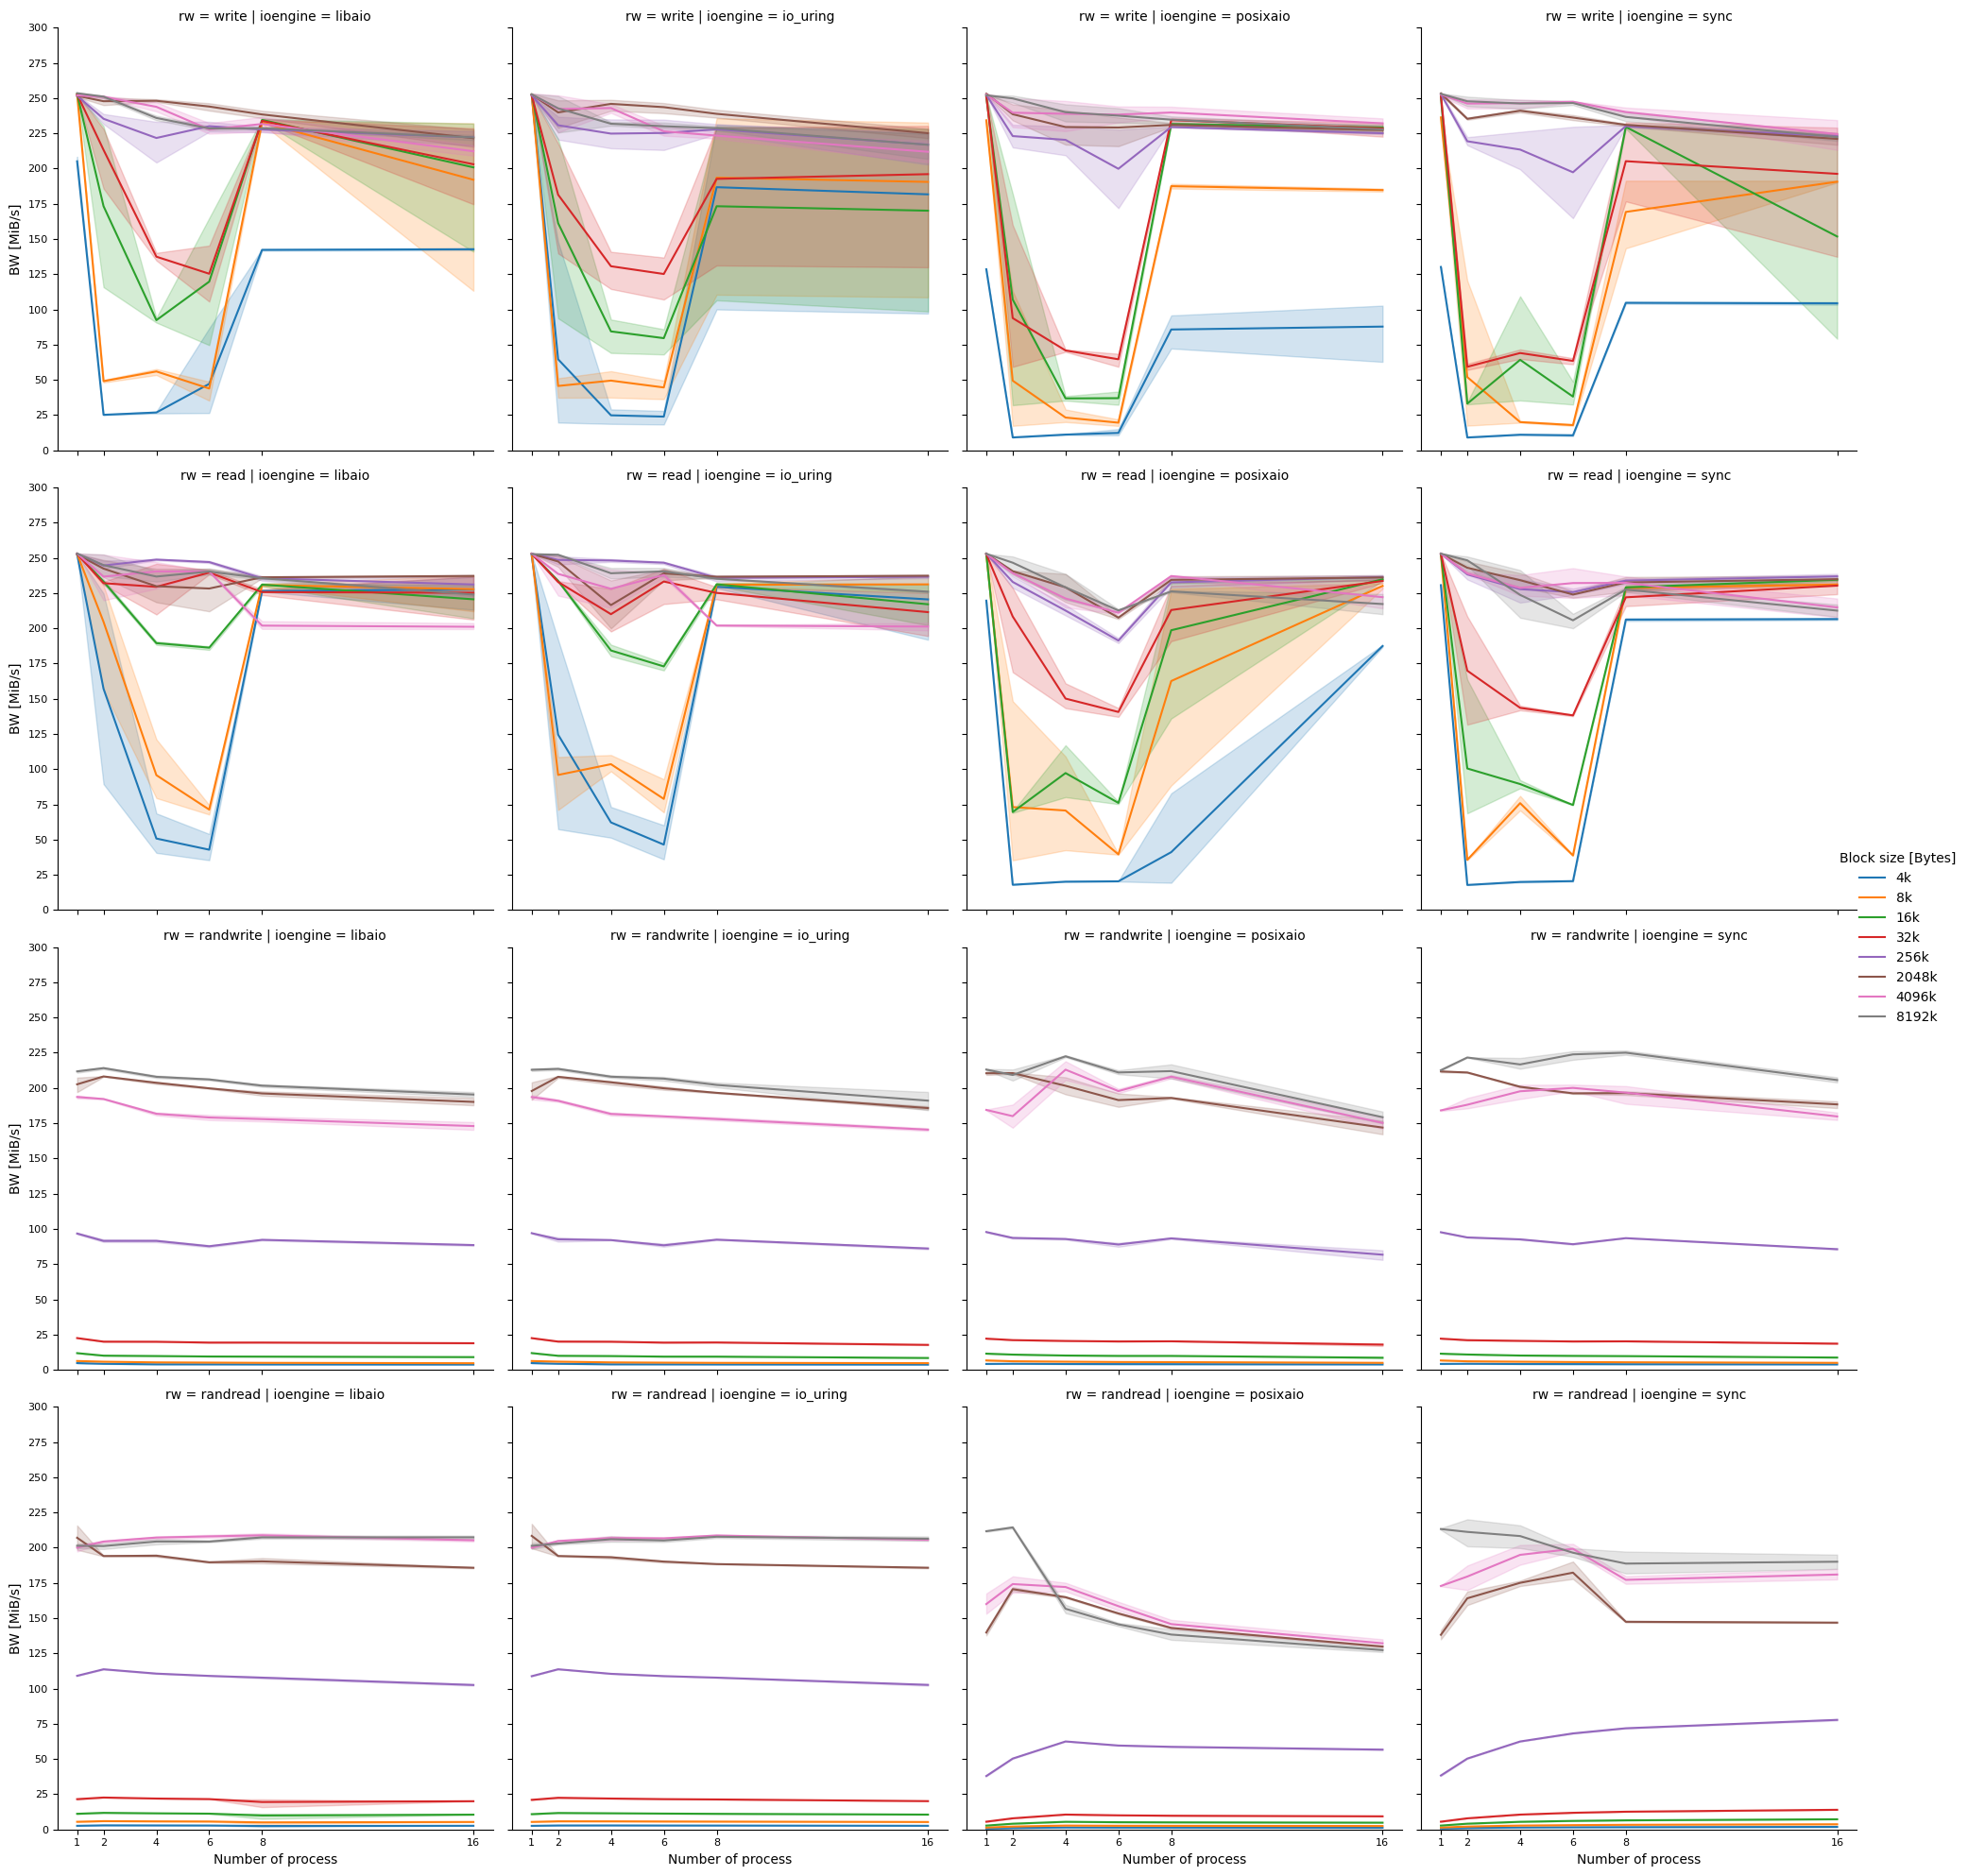

In [7]:
plt.figure(dpi=550)
plot_results('ext4',results)

In [8]:
print_table_max_mean_min(results,"ext4")

Result on ext4,test read
 Max 253.48879718780518 MiB/s
Result on ext4,test write
 Max 254.68302059173584 MiB/s
Result on ext4,test randread
 Max 674.991455078125 IOPS
Result on ext4,test randwrite
 Max 1218.087158203125 IOPS


## `zfs` I/O result

<Figure size 3520x2640 with 0 Axes>

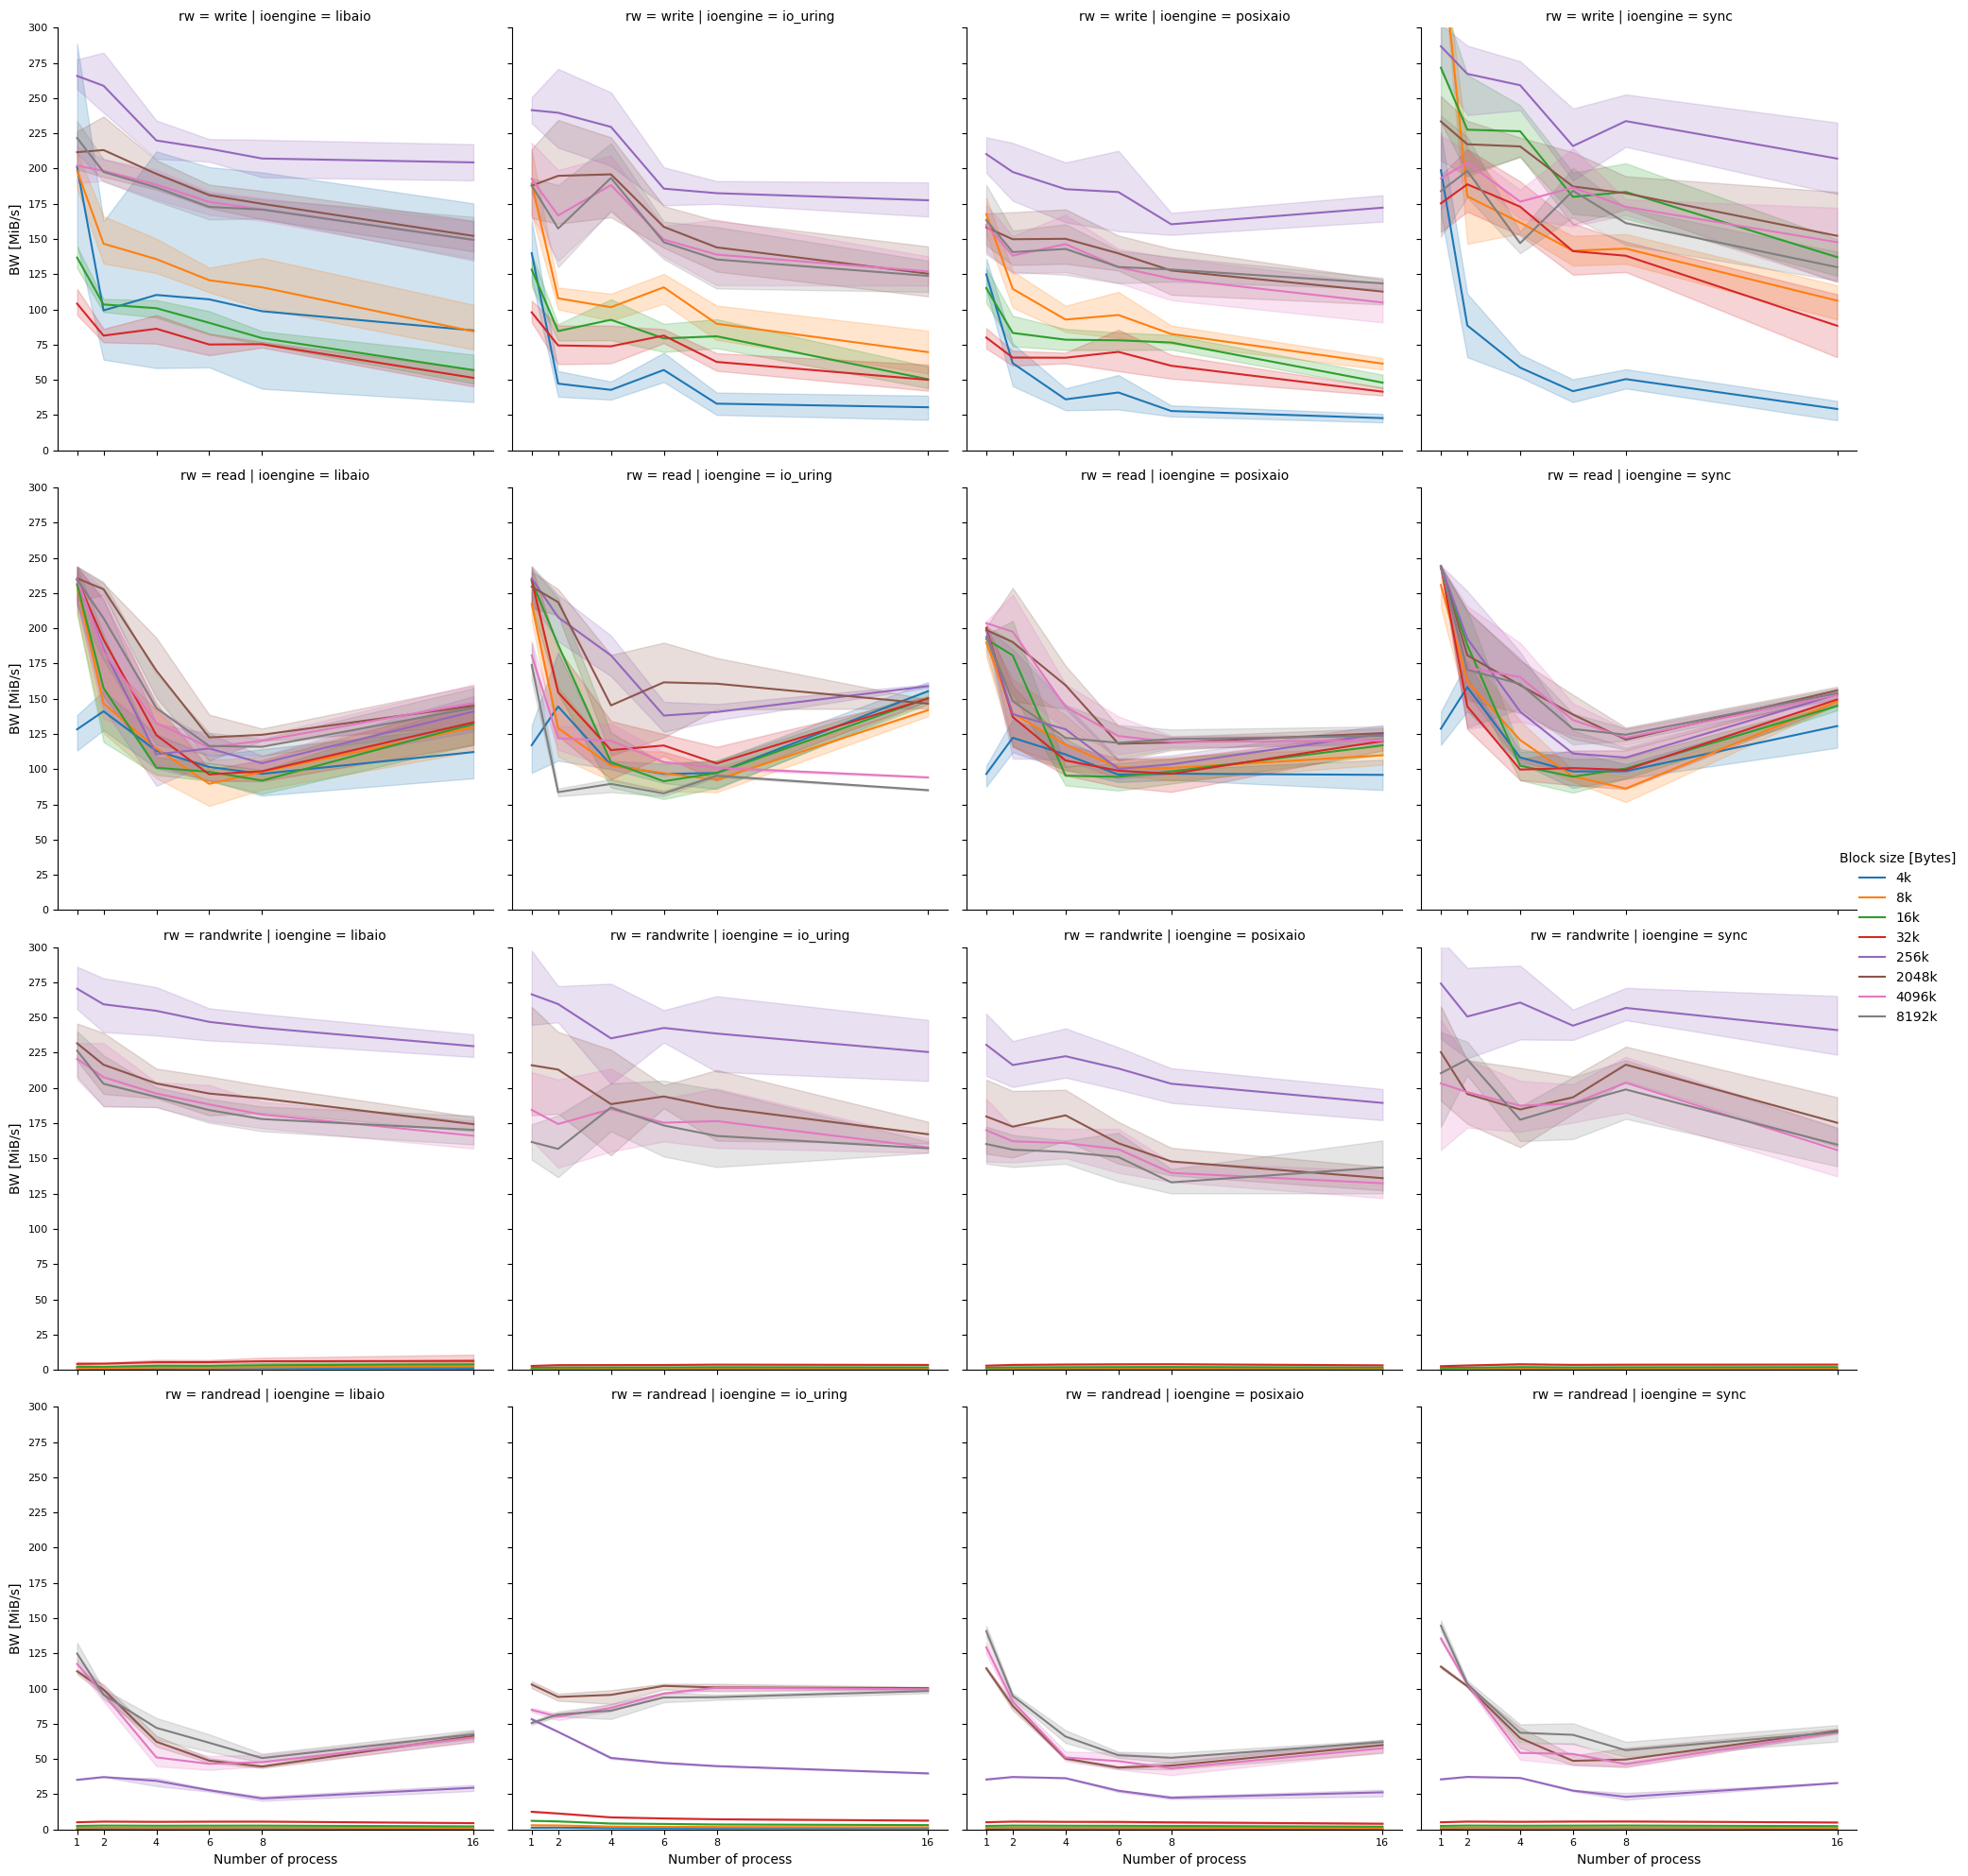

In [10]:
plt.figure(dpi=550)
plot_results('zfs',results)

In [18]:
print_table_max_mean_min(results,"zfs")

Result on zfs,test read
 Max 244.6503562927246 MiB/s
Result on zfs,test write
 Max 380.9609680175781 MiB/s
Result on zfs,test randread
 Max 334.954833984375 IOPS
Result on zfs,test randwrite
 Max 970.067138671875 IOPS


# Results summary

Only test with one `fio` job are reported and sequential `read` | `write`.

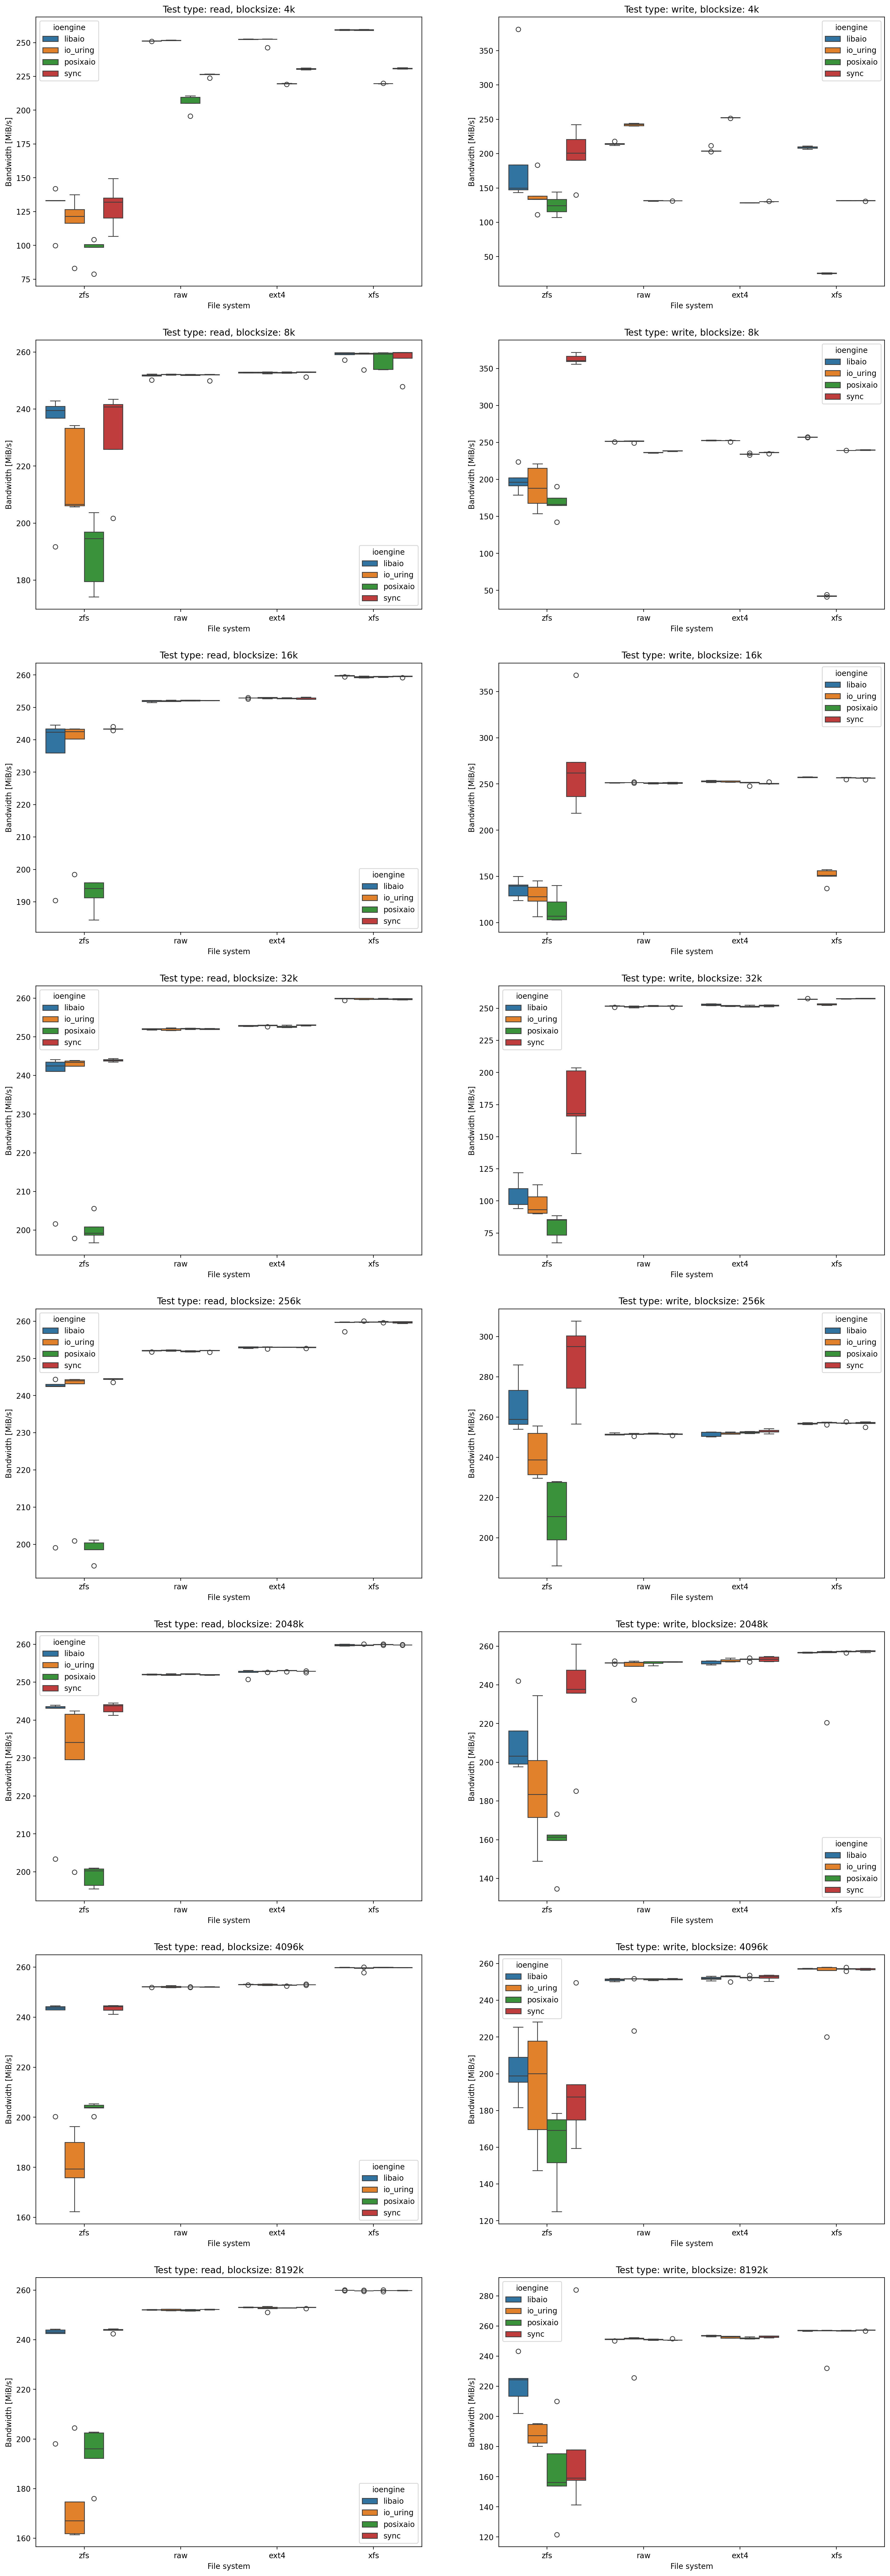

In [20]:
plt.figure(figsize=(20,60),dpi=200)
for i,mode in enumerate(["read","write"]):
    for j,bs in enumerate(['4k', '8k', '16k', '32k', '256k', '2048k', '4096k', '8192k']):
        plt.subplot(8, 2,2*j+i+1)
        sns.boxplot(data=results[(results['numjobs']==1) & (results['rw']==mode) & (results['bs']==bs)], x="fstype", y="bandwidth",hue="ioengine")
        plt.title(f"Test type: {mode}, blocksize: {bs}")
        plt.xlabel("File system")
        plt.ylabel("Bandwidth [MiB/s]")

### Scatterplot
This plot report also every single measure done, with different block size. 

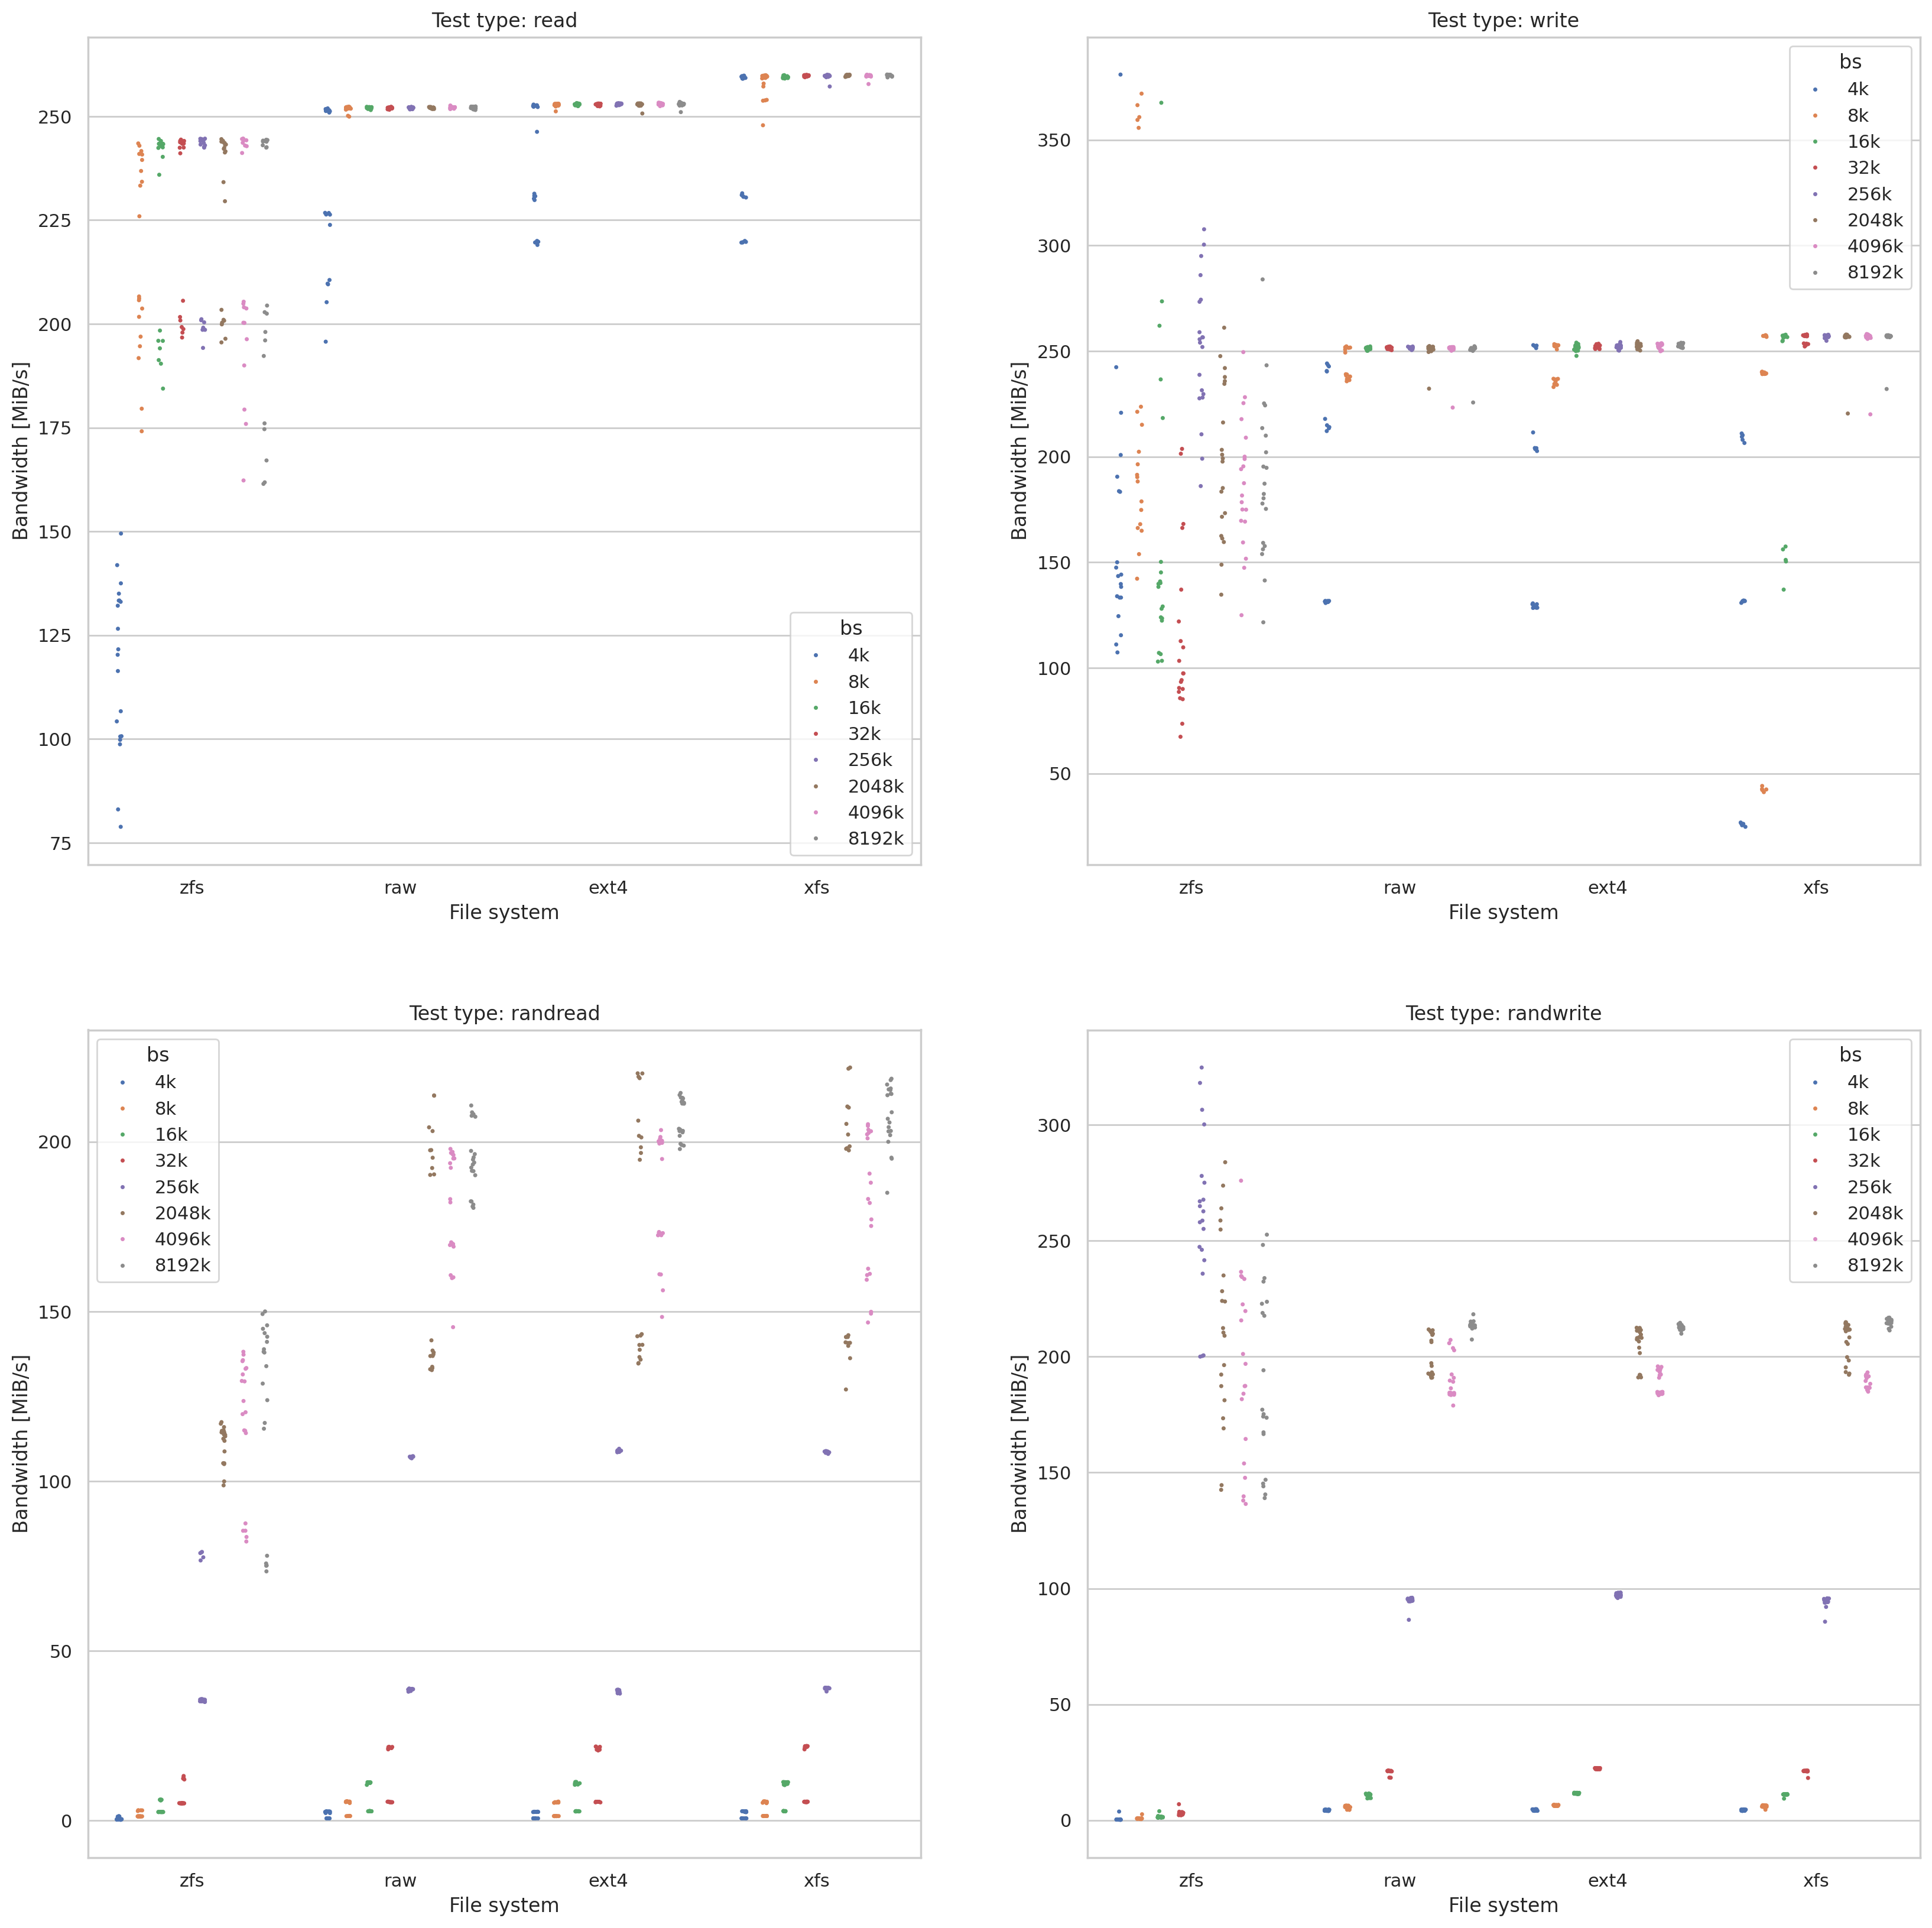

In [23]:
plt.figure(figsize=(20,20),dpi=200)
sns.set_theme(style="whitegrid")
for i,mode in enumerate(["read","write","randread","randwrite"]):
    plt.subplot(2, 2, i+1)
    ax = sns.stripplot(data=results[(results['numjobs']==1) & (results['rw']==mode)],  x="fstype", y="bandwidth",hue="bs",dodge=True,size=5, marker=".")
    ax.set(ylabel="")
    #sns.boxplot(data=results[(results['numjobs']==1) & (results['rw']==mode) & (results['bs']=="8k")], x="fstype", y="bandwidth",hue="ioengine")
    plt.title(f"Test type: {mode}")
    plt.xlabel("File system")
    plt.ylabel("Bandwidth [MiB/s]")

# CPU usage
The following scatter plot, report the CPU usage for all types of FS, number of jobs and block size.

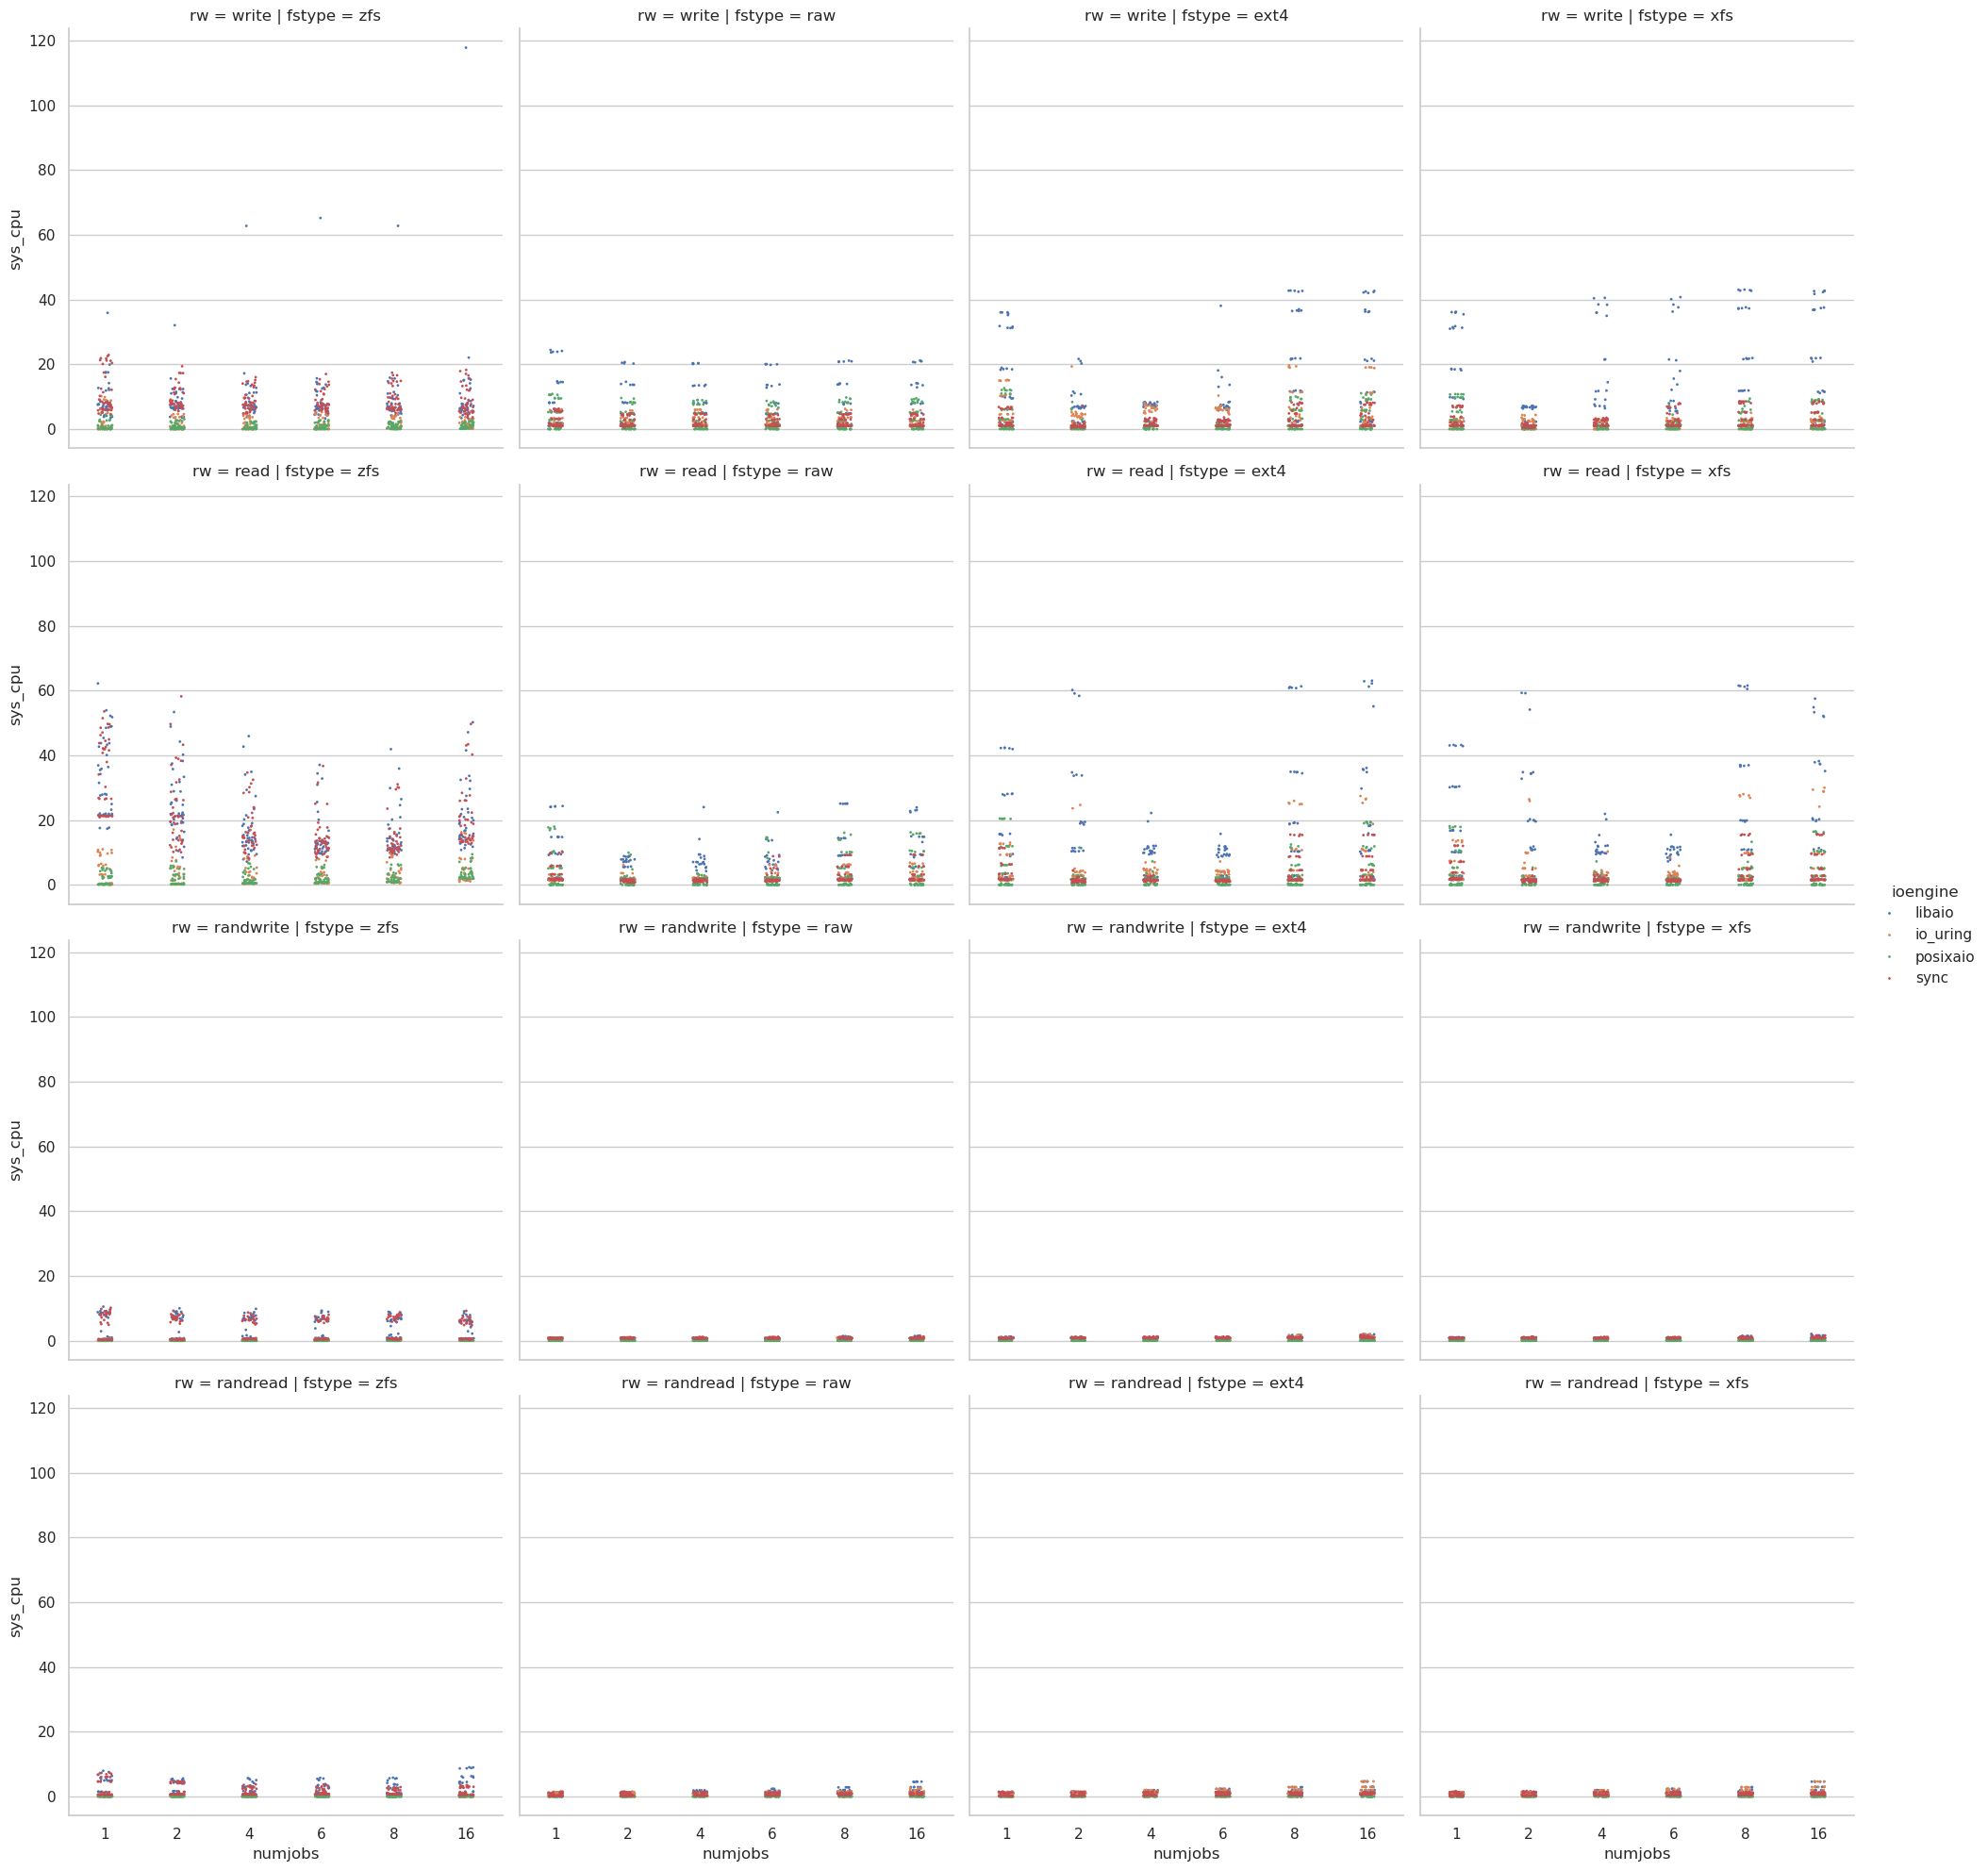

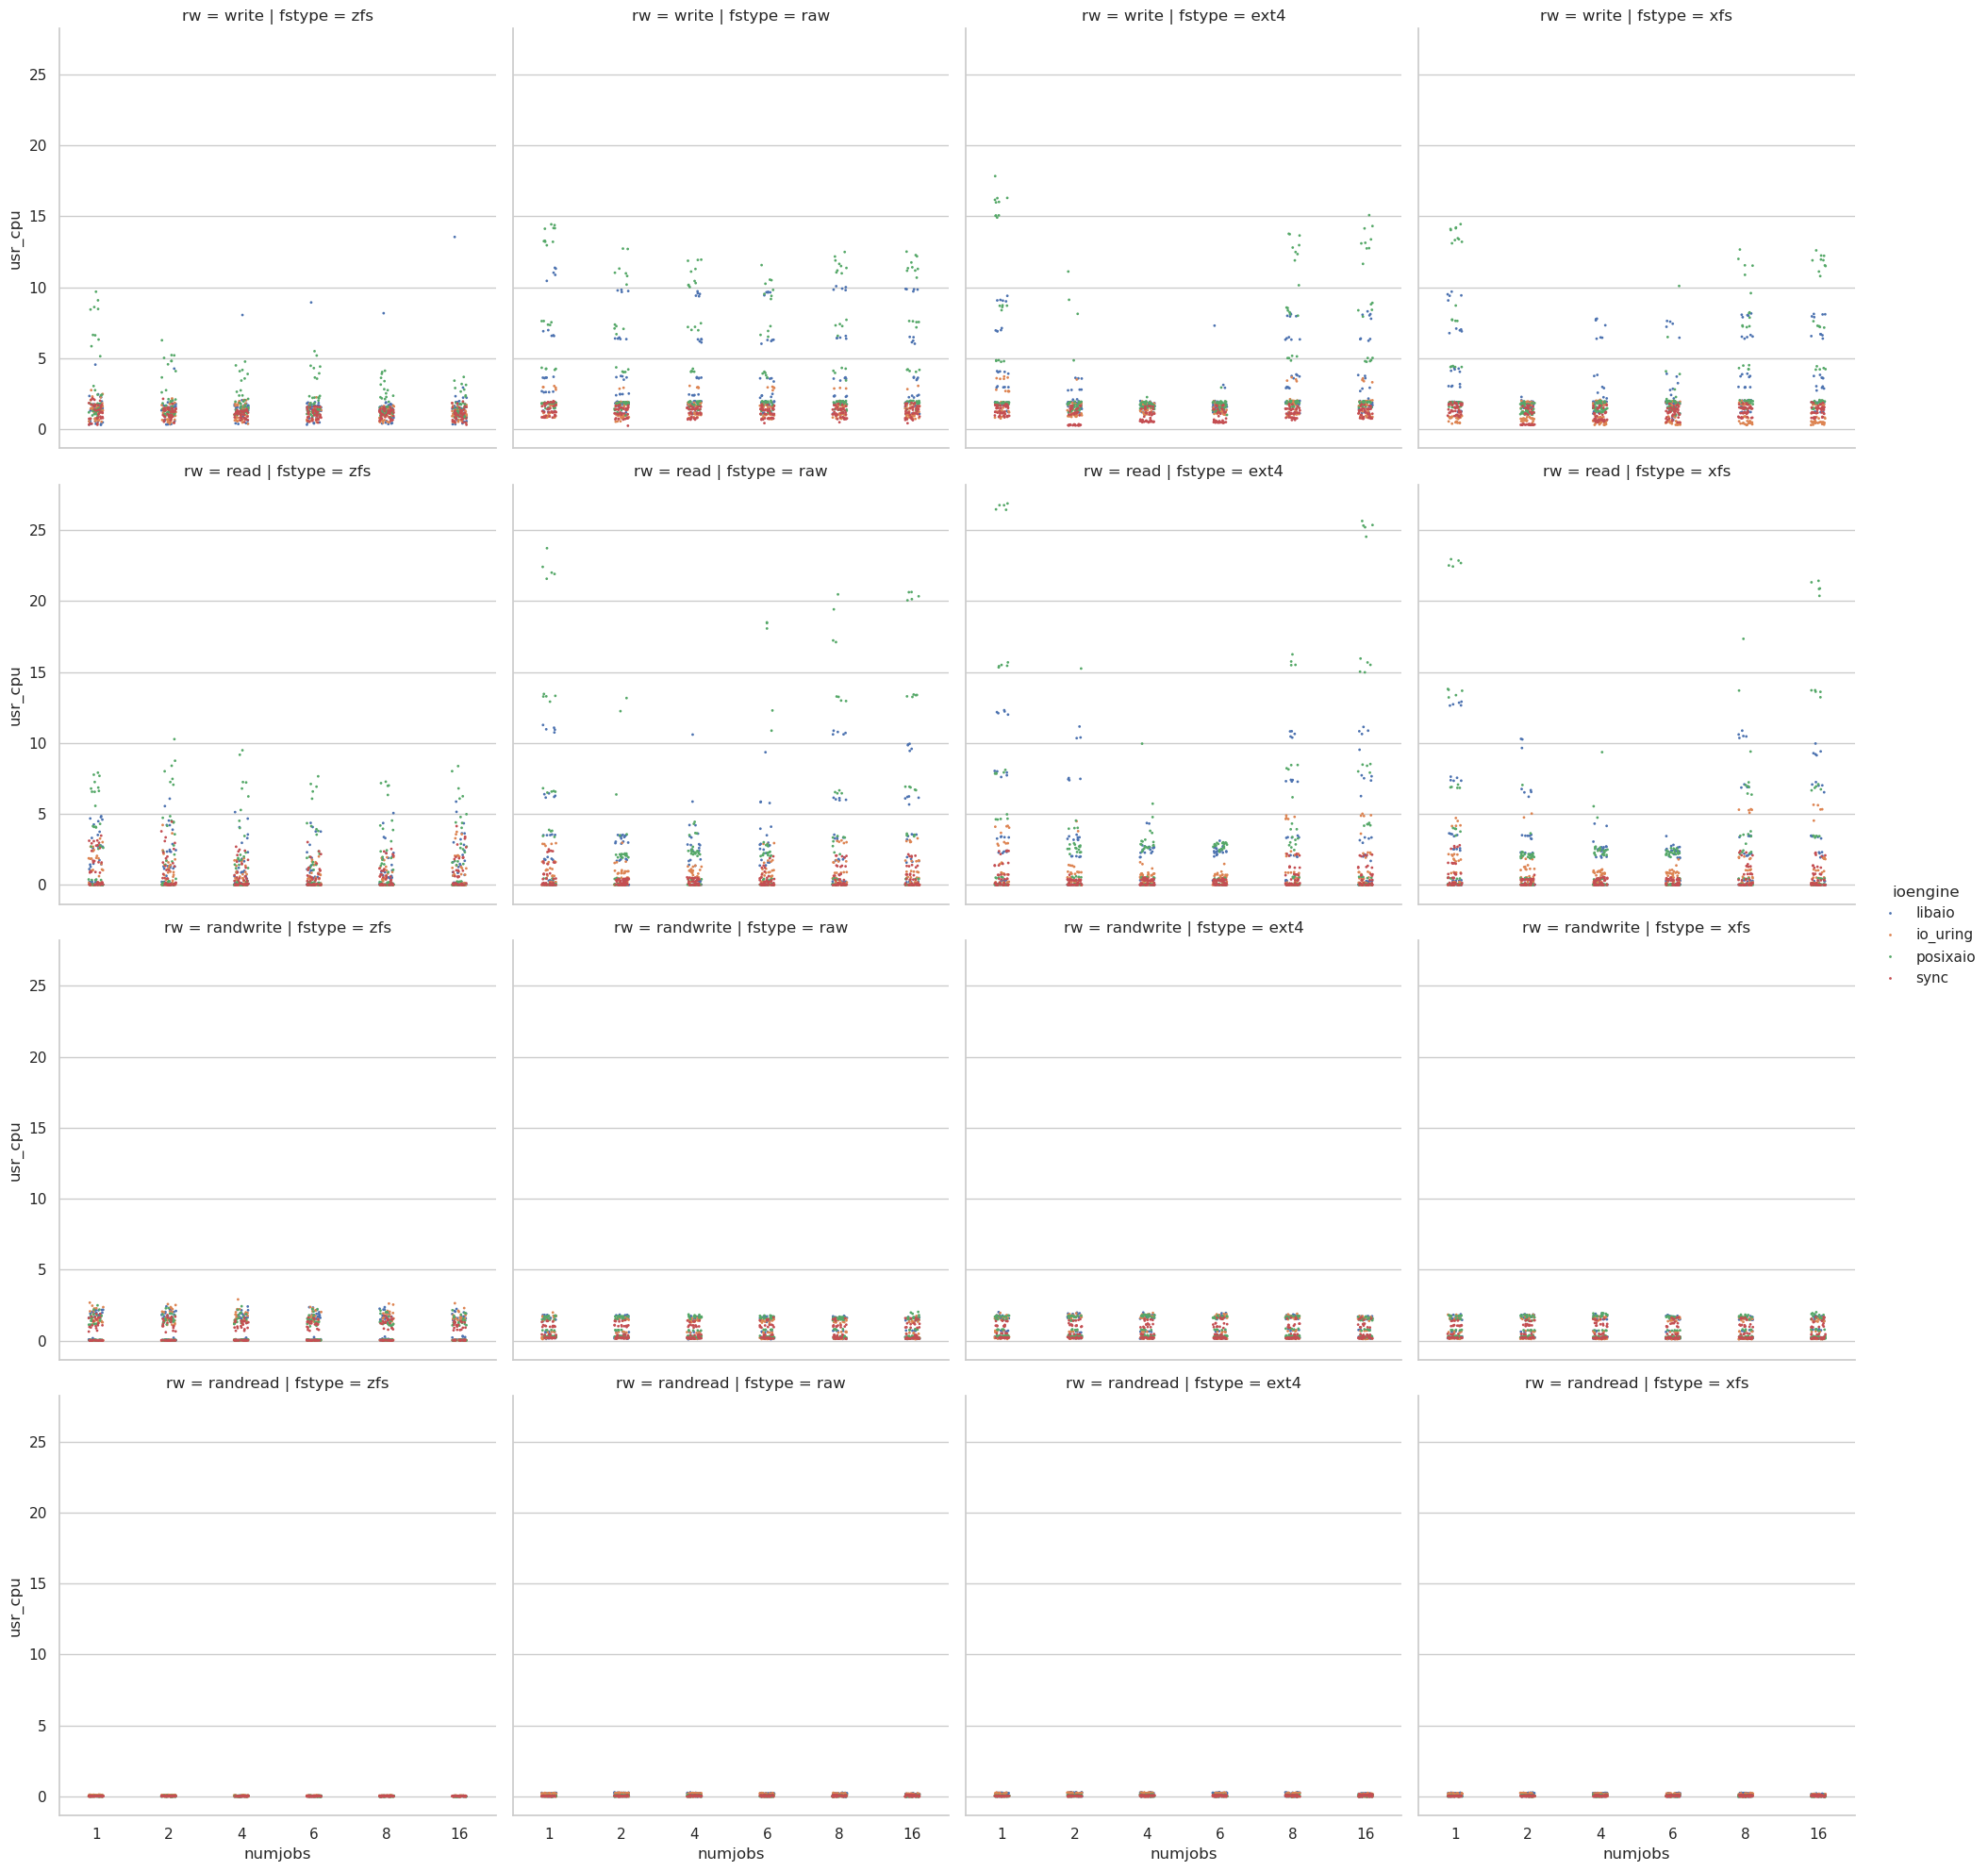

In [26]:
sns.catplot(
    data=results, x="numjobs", y="sys_cpu", col="fstype",hue="ioengine",row="rw",s=4)#, kind="boxen")
sns.catplot(
    data=results, x="numjobs", y="usr_cpu", col="fstype",hue="ioengine",row="rw",s=4)#, kind="boxen")
 

# More on blocksize

We performed an extensive series of test increasing the blocksize, in order to verify what happen while more than one job are writing / reading. This should give us more insight about the drop that we observed in the first plot with almost all FS.

In [38]:
def open_result_blocksize():
    #init an empty dataframe
    df = pd.DataFrame()
    
    for engine in range(1,6):
        with open(f'blocksize/results/bs-experiment_{engine}.json', 'r') as file:
            job = json.load(file)
            df_tmp=json_to_dataframe(job)
            df= pd.concat([df, df_tmp], ignore_index=True)
    df = df.astype({'numjobs':'int'})
    return df
    

In [39]:
blocksize=open_result_blocksize()

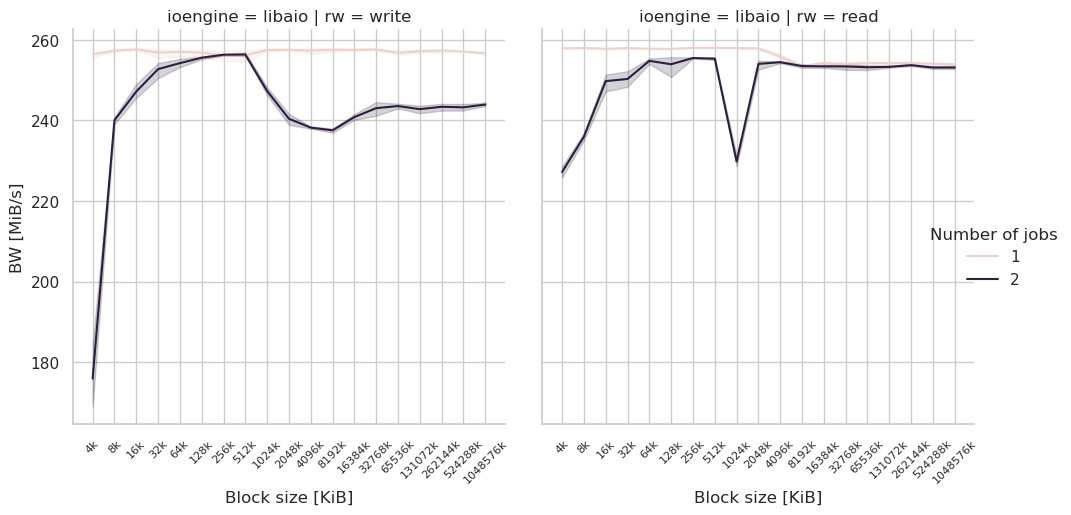

In [40]:
ax  = sns.relplot(
    data=blocksize, x="bs", y="bandwidth",col="rw", kind="line",hue="numjobs",row="ioengine")
ax.set(xlabel='Block size [KiB]', ylabel='BW [MiB/s]')
ax.legend.set_title("Number of jobs")
for a in ax.axes.flat:
    a.set_xticks(ticks=range(len(blocksize["bs"].unique()))) # useless, but usefull to suppress warning
    a.set_xticklabels(fontsize=8, rotation=45,labels=blocksize["bs"].unique())

# Disk controller assessment
Finally we assess the performance of the disk controller, in order to very that no bottleneck in terms of bandwidth are present while writing on all devices. So we increased the number of devices from 1 up to 12 and measured the aggregated BW. 

In [42]:
def open_result_perc():
    #init an empty dataframe
    df = pd.DataFrame()
    for mode in ["read","write"]:
        for device_count in range(1,13):
            for run_id in range(1,16):
                with open(f'perc/results/{mode}_disk_{device_count}_{run_id}.json', 'r') as file:
                    job = json.load(file)
                    job["device_count"]=device_count
                    df_tmp=json_to_dataframe(job)
                    df= pd.concat([df, df_tmp], ignore_index=True)
    #df = df.astype({'numjobs':'int'})
    return df
    

In [44]:
df=open_result_perc()

In [54]:
import numpy as np
def plot_results_perc(results):
    # Create the base plot
    ax = sns.relplot(
        data=results,
        kind="line",
        x="device_count", 
        y="bandwidth", 
        hue="rw",
        markers=True,  
        dashes=False,   
    )

    plt.xlim(1, 12)                     # Set x-axis from 1-12
    plt.xticks(range(1,13))             # Explicit tick marks
    
    ax.set_axis_labels("Number of devices", "Bandwidth [MiB/s]")
    
    x_line = np.array([1, 12])         
    y_line = 275 * x_line
    
    plt.plot(x_line, y_line, 
             linestyle='--', 
             color='gray',
             label='Theoretical Max (slope=275)')
    
    sns.set_style("whitegrid")        
    plt.legend()                      
    
    return ax

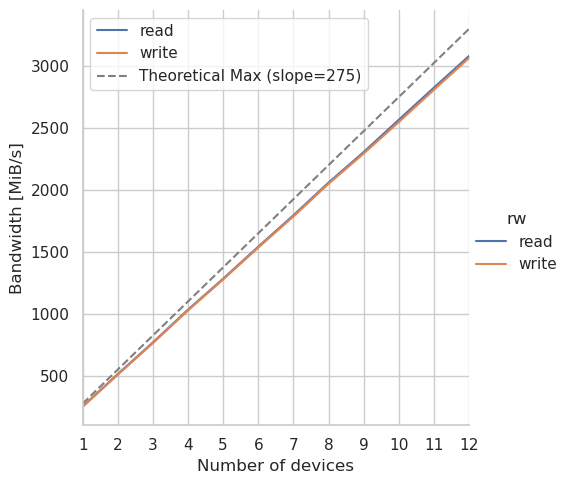

In [55]:
plot_results_perc(df)